In [71]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import daft

In [3]:
import theano
import theano.tensor as tt
theano.config.warn.round=False

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
sns.set_context('notebook')
sns.set_style('darkgrid')

-----

# Mixture models

We can construct very flexible new distributions using mixtures of other distributions. In fact, we can construct mixtures of not just distributions, but of regression models, neural networks etc, making this a very powerful framework. We consider finite and Dirichlet Process (DP) mixtures, and see basic ideas for how to work with mixtures in `pymc3`.

## The Categorical distribution

This is just the extension of the Bernoulli distribuiotn to more than 2 states.

In [10]:
cat = stats.multinomial(1, [0.1, 0.2, 0.3, 0.4])

In [11]:
cat.rvs(10)

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

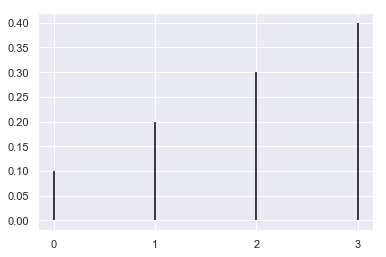

In [28]:
x = range(4)
plt.vlines(x, 0, cat.p)
plt.xticks(range(4))
pass

## The Dirichlet distribution

The code to visualize Dirichlet distributions in barycentric coordinates is from this [blog](http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/).

In [29]:
from functools import reduce
import matplotlib.tri as tri
from math import gamma
from operator import mul

In [30]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):

        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

<Figure size 432x288 with 0 Axes>

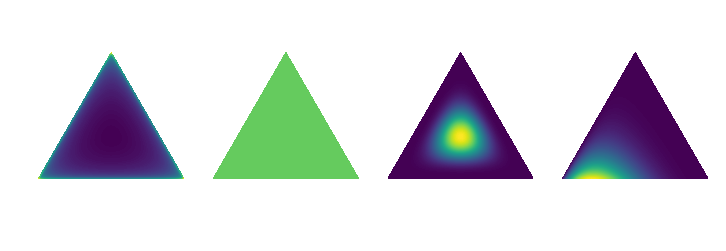

In [31]:
ks = (
    [0.999, 0.999, 0.999],
    [1,1,1],
    [5,5,5],
    [5,2,1],
)

plt.viridis()
fig = plt.figure(figsize=(12,4))
for i, k in enumerate(ks):
    plt.subplot(1,4,i+1)
    draw_pdf_contours(Dirichlet(k))

### Samples from Dirichlet distribution

In [32]:
n = 20
s = stats.dirichlet.rvs(alpha=[7,7,7], size=n).T

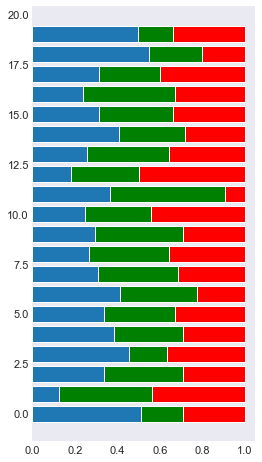

In [33]:
plt.figure(figsize=(4, n*0.4))
with plt.style.context('seaborn-dark'):
    plt.barh(range(n), s[0])
    plt.barh(range(n), s[1], left=s[0], color='g')
    plt.barh(range(n), s[2], left=s[0]+s[1], color='r')
pass

## Finite Gaussian Mixture Model

### Data

In [34]:
np.random.seed(1)
data = np.r_[np.random.normal(-6, 2, 500), 
          np.random.normal(0, 1, 200), 
          np.random.normal(4, 1, 300)]
n = data.shape[0]

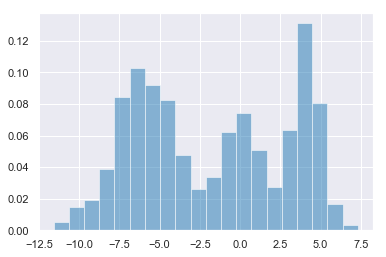

In [35]:
plt.hist(data, bins=20, normed=True, alpha=0.5)
pass

In [36]:
data.shape

(1000,)

### Explicit latent variable

In [37]:
k = 3

with pm.Model() as gmm1:
    p = pm.Dirichlet('p', a=np.ones(k))
    z = pm.Categorical('z', p=p, shape=data.shape[0])
    μ = pm.Normal('μ', 0, 10, shape=k)
    σ = pm.InverseGamma('τ', 1, 1, shape=k)
        
    y = pm.Normal('y', mu=μ[z], sd=σ[z], observed=data)

In [38]:
with gmm1:
    trace = pm.sample(n_init=10000, tune=1000, random_seed=123)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [τ, μ, p]
>CategoricalGibbsMetropolis: [z]
Sampling 4 chains: 100%|██████████| 6000/6000 [05:39<00:00,  4.63draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


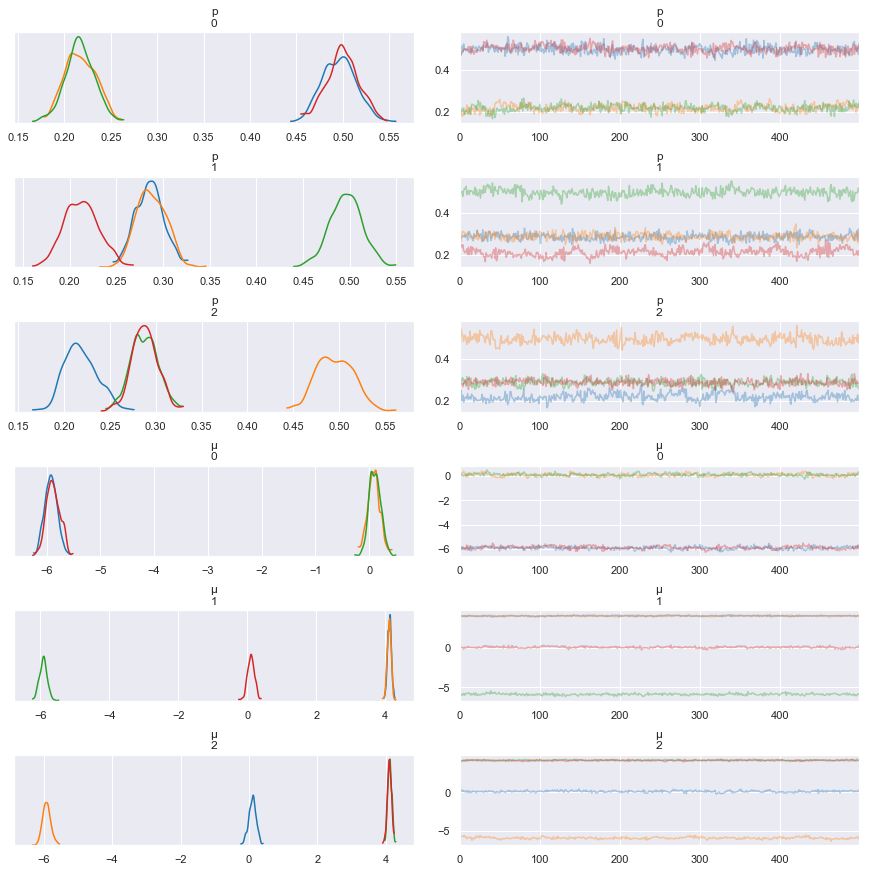

In [39]:
pm.traceplot(trace, varnames=['p', 'μ', 'σ'])
pass

Note that the sampler is quite slow and convergence is poor. This is due to the need to sample over the discrete latent variable $z$. We can improve convergence by marginalizing out $z$.

100%|██████████| 10/10 [00:00<00:00, 181.99it/s]


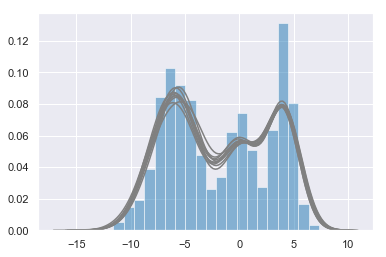

In [40]:
with gmm1:
    ppc = pm.sample_posterior_predictive(trace, samples=10)

plt.hist(data, bins=20, normed=True, alpha=0.5)
for i in range(10):
    sns.distplot(ppc['y'][i], hist=False, color='grey')

### Marginalization

$$
f(x | p) = \sum_{i=1}^{k} p_i N(\mu, \sigma)
$$


In [41]:
k = 3

with pm.Model() as gmm2:
    p = pm.Dirichlet('p', a=np.ones(k))
    μ = pm.Normal('μ', 0, 10, shape=k)
    σ = pm.InverseGamma('τ', 1, 1, shape=k)
        
    y = pm.NormalMixture('y', p, mu=μ, sd=σ, observed=data)

In [42]:
with gmm2:
    trace = pm.sample(n_init=10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, μ, p]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:08<00:00, 672.90draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


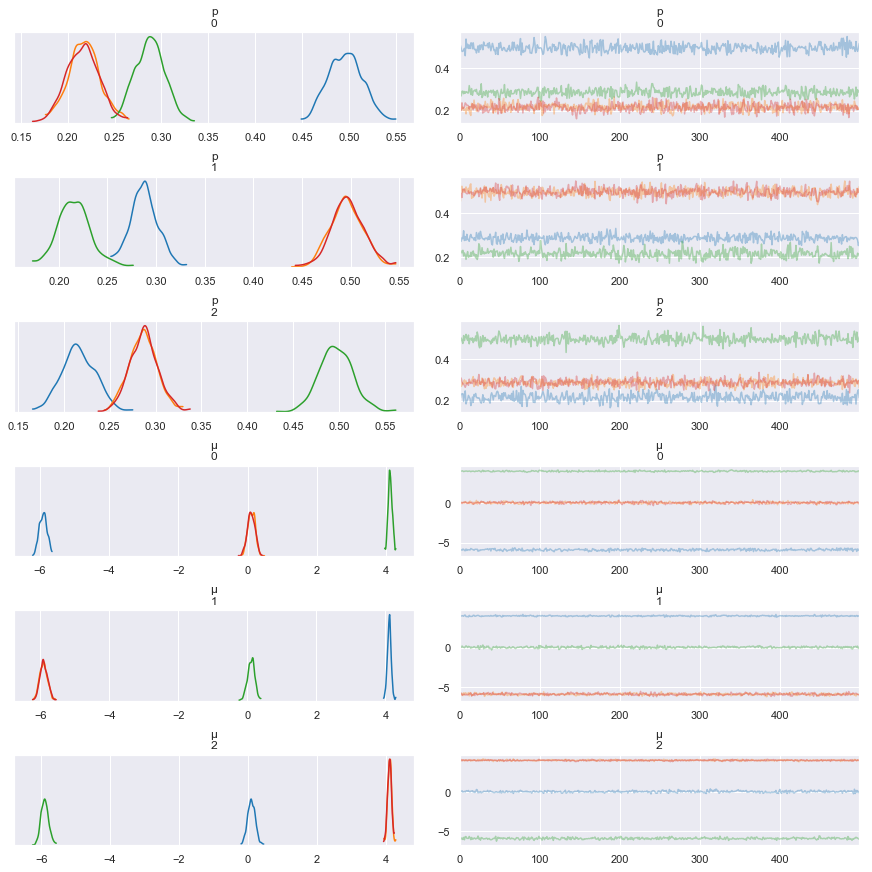

In [43]:
pm.traceplot(trace, varnames=['p', 'μ', 'σ'])
pass

100%|██████████| 10/10 [00:00<00:00, 14.91it/s]


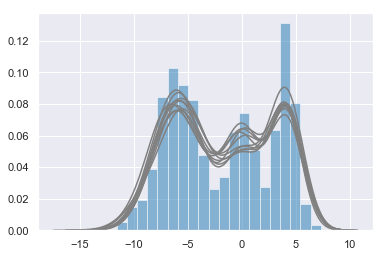

In [44]:
with gmm2:
    ppc = pm.sample_posterior_predictive(trace, samples=10)

plt.hist(data, bins=20, normed=True, alpha=0.5)
for i in range(10):
    sns.distplot(ppc['y'][i], hist=False, color='grey')

### The Label-Switching problem

In [45]:
k = 3

with pm.Model() as gmm3:
    p = pm.Dirichlet('p', a=np.ones(k))
    μ = pm.Normal('μ', np.linspace(data.min(), data.max(), k)
                  , sd=10, shape=k)
    σ = pm.InverseGamma('τ', 1, 1, shape=k)
        
    op = pm.Potential('op', 
                      tt.switch(μ[1]-μ[0] < 0, -np.inf, 0) + 
                      tt.switch(μ[2]-μ[1] < 0, -np.inf, 0))
        
    y = pm.NormalMixture('y', p, mu=μ, sd=σ, observed=data)

In [46]:
with gmm3:
    trace = pm.sample(n_init=10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, μ, p]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:13<00:00, 440.40draws/s]
The acceptance probability does not match the target. It is 0.9245971316563495, but should be close to 0.8. Try to increase the number of tuning steps.


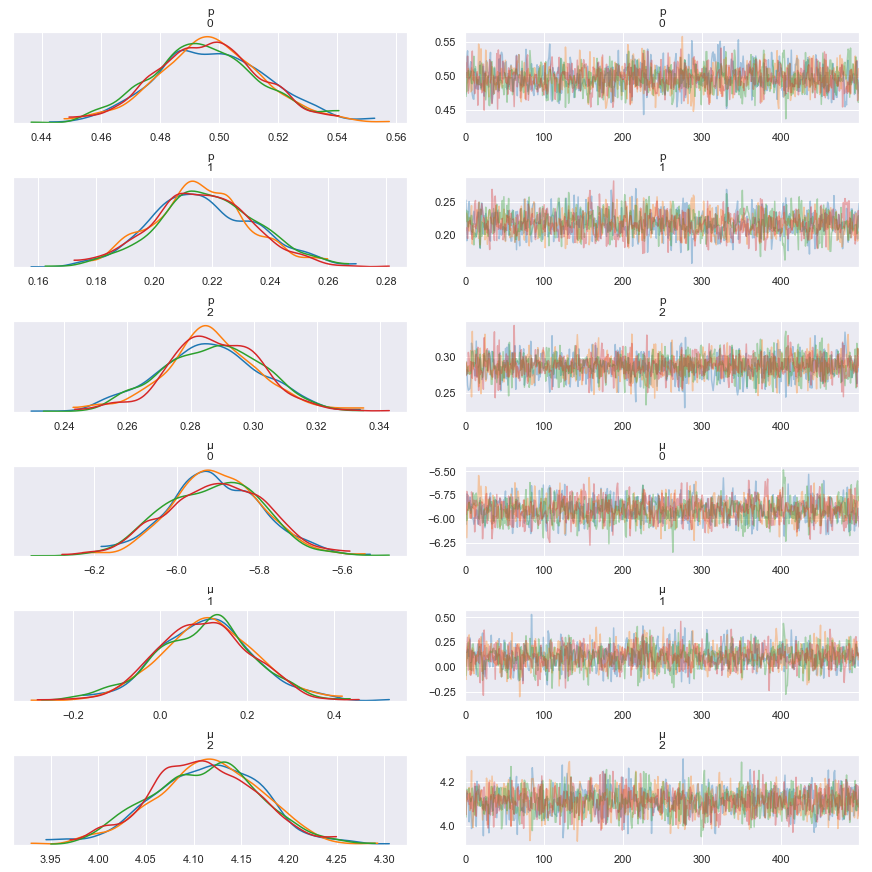

In [47]:
pm.traceplot(trace, varnames=['p', 'μ', 'σ'])
pass

100%|██████████| 10/10 [00:00<00:00, 15.21it/s]


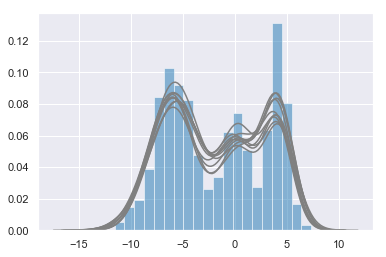

In [48]:
with gmm3:
    ppc = pm.sample_posterior_predictive(trace, samples=10)

plt.hist(data, bins=20, normed=True, alpha=0.5)
for i in range(10):
    sns.distplot(ppc['y'][i], hist=False, color='grey')

### Alternative for label switching

In [49]:
k = 3

with pm.Model() as gmm4:
    p = pm.Dirichlet('p', a=np.ones(k))
    μ = pm.Normal('μ', 
                  np.linspace(data.min(), data.max(), k), 
                  sd=10, 
                  shape=k, 
                  transform=pm.distributions.transforms.ordered)
    σ = pm.InverseGamma('τ', 1, 1, shape=k)
        
    y = pm.NormalMixture('y', p, mu=μ, sd=σ, observed=data)

In [50]:
with gmm4:
    trace = pm.sample(n_init=10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, μ, p]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:17<00:00, 334.60draws/s]


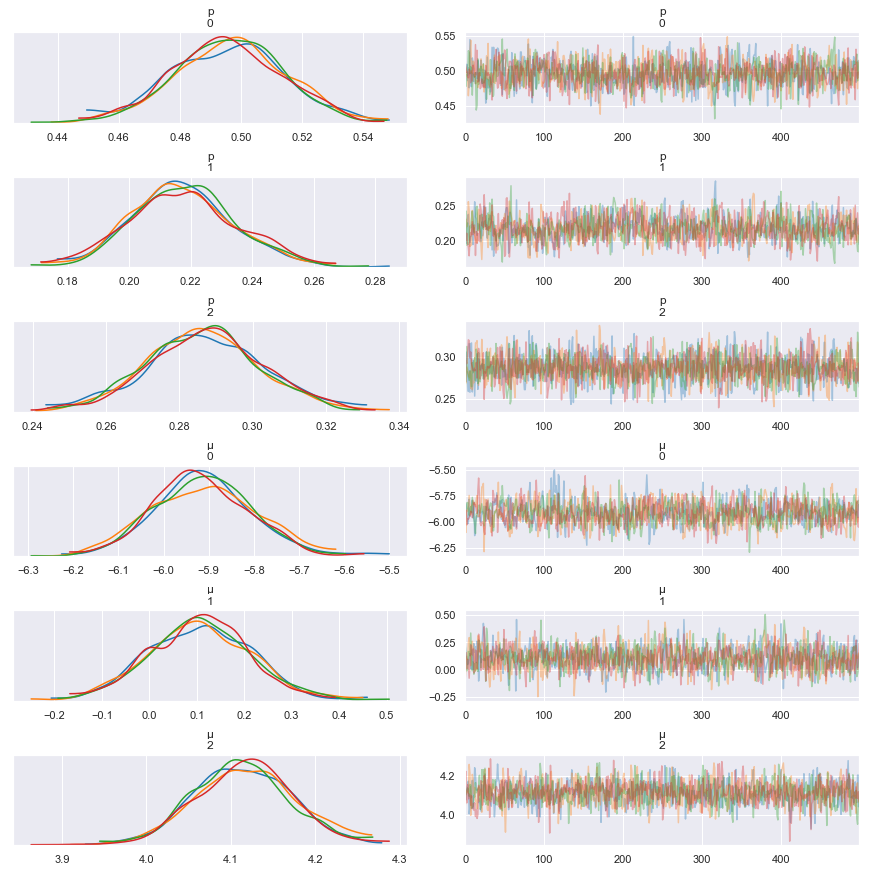

In [51]:
pm.traceplot(trace, varnames=['p', 'μ', 'σ'])
pass

100%|██████████| 10/10 [00:00<00:00, 15.51it/s]


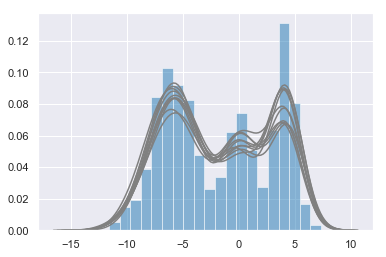

In [52]:
with gmm4:
    ppc = pm.sample_posterior_predictive(trace, samples=10)

plt.hist(data, bins=20, normed=True, alpha=0.5)
for i in range(10):
    sns.distplot(ppc['y'][i], hist=False, color='grey')

## Dirichlet process

### Samples from DP

In [53]:
def sbp0(α, k, base=stats.norm(0,1)):
    β = stats.beta.rvs(1, α, size=k)
    w = β * np.r_[[1], (1 - β[:-1]).cumprod()]
    x = base.rvs(size=k)
    return w, x

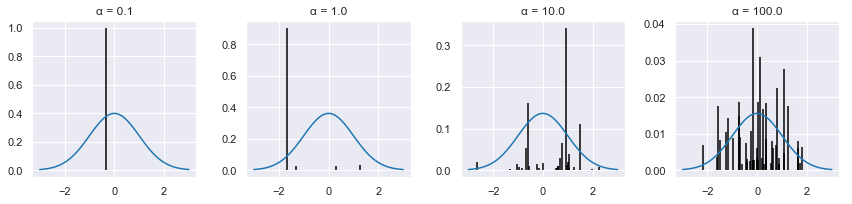

In [56]:
k = 50

xp = np.linspace(-3,3,100)
np.random.seed(123)
plt.figure(figsize=(12,3))
for i, α in enumerate([0.1, 1,10,100]):
    plt.subplot(1, 4, i+1)
    w, x = sbp0(α, k)
    plt.vlines(x, 0, w)
    plt.plot(xp, w.max()*stats.norm(0,1).pdf(xp))
    plt.title('α = %.1f' % α)
plt.tight_layout()

### DP mixture model

#### Generative process

In [57]:
np.random.seed(123)
α = 1
k = 20

w, x = sbp0(α, k)
dist = stats.norm(x, 0.5)

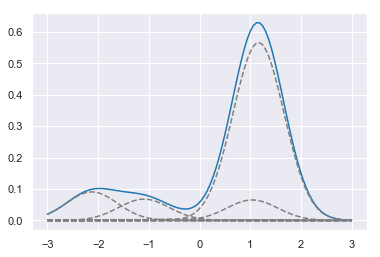

In [58]:
xp = np.transpose([np.linspace(-3,3,100)]*k)
plt.plot(xp[:,0], (w*dist.pdf(xp)).sum(1))
plt.plot(xp, w*dist.pdf(xp), c='grey', ls='--')
pass

### Fitting to data

In [59]:
def sbp(α, k=20):
    β = pm.Beta('β', 1, α, shape=k)
    w = β * pm.math.concatenate([[1], (1 - β[:-1]).cumprod()])
    return w

In [60]:
with pm.Model() as dpgmm:
    α = pm.Gamma('α', 1, 1)
    p = pm.Deterministic('p', sbp(α))
    μ = pm.Normal('μ', 
                  np.linspace(data.min(), data.max(), k), 
                  sd=10, 
                  shape=k, 
                  transform=pm.distributions.transforms.ordered)
    σ = pm.InverseGamma('τ', 1, 1, shape=k)
        
    y = pm.NormalMixture('y', p, mu=μ, sd=σ, observed=data)

In [61]:
with dpgmm:
    trace = pm.sample(n_init=10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ, μ, β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [13:16<00:00,  2.71draws/s]
There were 188 divergences after tuning. Increase `target_accept` or reparameterize.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
There were 278 divergences after tuning. Increase `target_accept` or reparameterize.
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x152654940>,
      dtype=object)

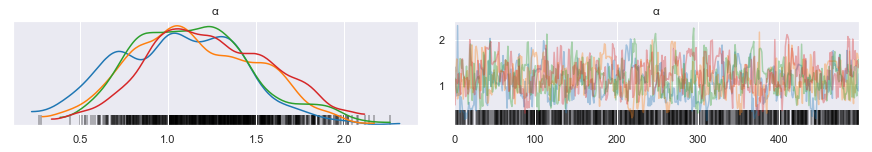

In [74]:
pm.traceplot(trace, varnames=['α'])
pass

Check that a truncation level of k=20 is sufficient.

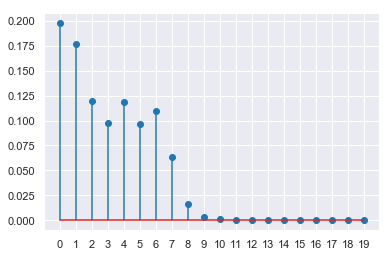

In [82]:
plt.stem(trace['p'].mean(axis=0))
plt.xticks(range(20))
pass